## Introduction

In this notebook, we're going to learn all about Decision Tree, by building one from scratch, and using it to submit to the Titanic competition! That might sound like a pretty big stretch, but I think you'll be surprised to discover how straightforward it actually is.

We'll start by importing the basic set of libraries we normally need for data science work, and setting numpy to use our display space more efficiently:

In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=100)

## Data preprocessing

reading data

In [3]:
import os

df = pd.read_csv('./train.csv')
tst_df = pd.read_csv('./test.csv')
modes = df.mode().iloc[0]
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


We can transform these fields into categorical variables. In Pandas, this conversion essentially enumerates the unique column values, replacing each unique value with a corresponding index.

In [4]:
def proc_data(df): # Define a function to process the data
    df['Fare'] = df.Fare.fillna(0) # Fill any missing values in the 'Fare' column with 0
    df.fillna(modes, inplace=True) # Fill any missing values in other columns with pre-calculated modes (commonly occurring values)
    
    df['LogFare'] = np.log1p(df['Fare']) # Create a new column 'LogFare' which is the logarithm (plus 1) of the 'Fare' column to handle cases where Fare might be 0
    df['Embarked'] = pd.Categorical(df.Embarked) # Convert the 'Embarked' column to a categorical datatype, facilitating encoding for modeling
    df['Sex'] = pd.Categorical(df.Sex) # Convert the 'Sex' column to a categorical datatype

proc_data(df) # Apply the function to the main data (commonly training data)
proc_data(tst_df) # Apply the function to the test data
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S,2.639057
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,3.433987
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S,3.196630
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3.433987


Let's categorize our data into continuous, categorical, and dependent variables. Notably, Pclass is no longer deemed a categorical variable. Its nature is ordered – 1st, 2nd, and 3rd classes possess a distinct hierarchy. As we'll discover, decision trees primarily focus on this order, rather than the absolute value.

In [5]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

Even although we've made the `cats` columns categorical, they are still shown by Pandas as their original values:

In [6]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

## Binary splits

To embark on the Decision Tree journey, we must first grasp the concept of a decision tree, the foundation of numerous models.

At the heart of a decision tree lies a binary split. This mechanism sorts rows into one of two groups, contingent on whether they surpass a given column threshold. For instance, dividing our data based on gender – using 0.5 as a threshold for the Sex column (where 0 stands for female and 1 for male) – is a practical illustration. To visualize this, we'll employ the Seaborn library, an enhancement of matplotlib, offering intuitive charts with an appealing design.

/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/categorical.py:

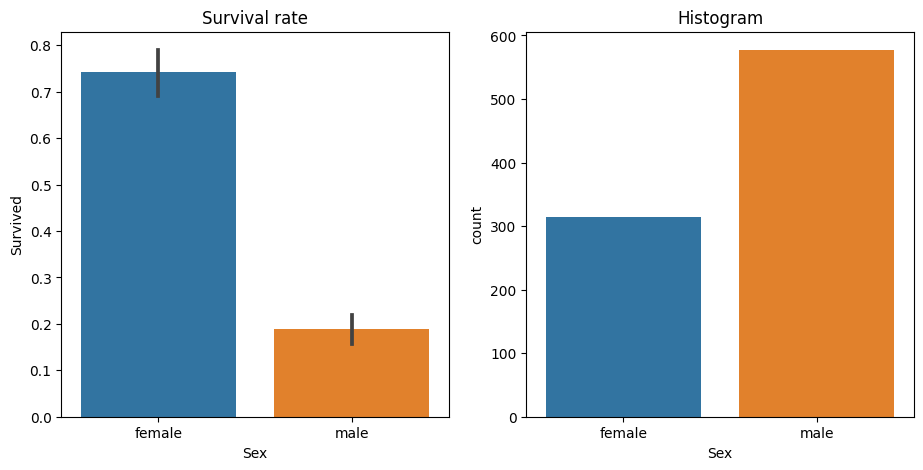

In [7]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

The resulting visualization underscores two salient points: First, when segregated by gender, survival rates vary significantly – over 70% for females and below 20% for males. Second, the distribution is balanced, with each group comprising over 300 of the approximately 900 passengers.

Given these insights, we could draft a rudimentary model positing that all females survive, while males don't. Before this, it's prudent to partition our data into training and validation sets, assessing the accuracy of such a premise.

In [8]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(6100)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

(In the previous step we also replaced the categorical variables with their integer codes, since some of the models we'll be building in a moment require that.)

Now we can create our independent variables (the `x` variables) and dependent (the `y` variable):

In [9]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

Here's the predictions for our extremely simple model, where `female` is coded as `0`:

In [10]:
preds = val_xs.Sex==0

We'll use mean absolute error to measure how good this model is:

In [11]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.18385650224215247

Alternatively, we could try splitting on a continuous column. We have to use a somewhat different chart to see how this might work -- here's an example of how we could look at `LogFare`:

/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raymon/miniconda3/envs/d2l/lib/python3.9/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ve

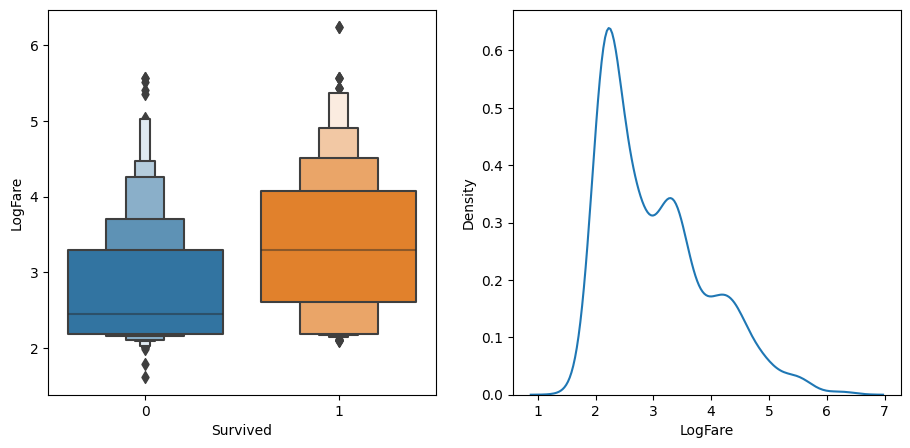

In [12]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

The [boxenplot](https://seaborn.pydata.org/generated/seaborn.boxenplot.html) above shows quantiles of `LogFare` for each group of `Survived==0` and `Survived==1`. It shows that the average `LogFare` for passengers that didn't survive is around `2.5`, and for those that did it's around `3.2`. So it seems that people that paid more for their tickets were more likely to get put on a lifeboat.

Let's create a simple model based on this observation:

In [13]:
preds = val_xs.LogFare>2.6

...and test it out:

In [14]:
mean_absolute_error(val_y, preds)

0.3901345291479821

This is quite a bit less accurate than our model that used `Sex` as the single binary split.

Ideally, we'd like some way to try more columns and breakpoints more easily. We could create a function that returns how good our model is, in order to more quickly try out a few different splits. We'll create a `score` function to do this. Instead of returning the mean absolute error, we'll calculate a measure of *impurity* -- that is, how much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.

We can measure the similarity of rows inside a group by taking the standard deviation of the dependent variable. If it's higher, then it means the rows are more different to each other. We'll then multiply this by the number of rows, since a bigger group as more impact than a smaller group:

In [15]:
def _side_score(side, y):
    """
    Calculate the score for a given side (subset) of a binary split.
    
    :param side: Boolean array indicating which rows are in this subset.
    :param y: Target values for the dataset.
    :return: Score for this subset, considering its size and target values' variability.
    """
    
    # Calculate the total number of True values in the side, representing the size of this subset.
    tot = side.sum()
    
    # If the subset size is less than or equal to 1, return a score of 0.
    # This means this subset doesn't provide enough information.
    if tot <= 1: 
        return 0
    
    # Return the score as the standard deviation of target values in this subset multiplied by its size.
    # This considers both the variability in target values and the size of the subset.
    return y[side].std() * tot


Now we've got that written, we can calculate the score for a split by adding up the scores for the "left hand side" (lhs) and "right hand side" (rhs):

In [16]:
def score(col, y, split):
    """
    Calculate the score for a given binary split of a column against a target variable.
    
    :param col: Column values on which the split is performed.
    :param y: Target values for the dataset.
    :param split: Threshold value for the binary split.
    :return: Score for this binary split, based on its two subsets.
    """
    
    # Create a boolean array indicating which rows fall to the left-hand side (lhs) of the split.
    # Rows with values less than or equal to the split threshold are on the lhs.
    lhs = col <= split
    
    # Calculate scores for both the left-hand side (lhs) and the right-hand side (~lhs) of the split.
    # Then, return the average of the two scores, weighted by the size of the dataset.
    return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)

For instance, here's the impurity score for the split on `Sex`:

In [17]:
score(trn_xs["Sex"], trn_y, 0.5)

0.41537513837432405

...and for `LogFare`:

In [18]:
score(trn_xs["LogFare"], trn_y, 2.6)

0.4634161904669958

As we'd expect from our earlier tests, `Sex` appears to be a better split.

To make it easier to find the best binary split, we can create a simple interactive tool (note that this only works in Kaggle):

In [19]:
"""
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);
"""

'\ndef iscore(nm, split):\n    col = trn_xs[nm]\n    return score(col, trn_y, split)\n\nfrom ipywidgets import interact\ninteract(nm=conts, split=15.5)(iscore);\n'

Try selecting different columns and split points using the dropdown and slider above. What splits can you find that increase the purity of the data?

We can do the same thing for the categorical variables:

In [20]:
#interact(nm=cats, split=2)(iscore);

That works well enough, but it's rather slow and fiddly. Perhaps we could get the computer to automatically find the best split point for a column for us? For example, to find the best split point for `age` we'd first need to make a list of all the possible split points (i.e all the unique values of that field)...:

In [21]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,
        9.  , 10.  , 11.  , 13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  , 28.5 , 29.  , 30.  ,
       31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 37.  , 38.  , 39.  , 40.  , 40.5 ,
       41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  ,
       53.  , 54.  , 55.  , 55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 71.  , 80.  ])

...and find which index of those values is where `score()` is the lowest:

In [22]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

Based on this, it looks like, for instance, that for the `Age` column, `6` is the optimal cutoff according to our training set.

We can write a little function that implements this idea:

In [23]:
# Define a function that finds the best binary split for a given column.
def min_col(df, nm):
    # Extract the desired column and the dependent variable from the dataframe.
    col, y = df[nm], df[dep]
    
    # Get unique non-null values from the column.
    unq = col.dropna().unique()
    
    # Calculate the score for each unique value, skipping NaN values.
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    
    # Find the index of the best (minimum) score.
    idx = scores.argmin()
    
    # Return the unique value associated with the best score and the best score itself.
    return unq[idx], scores[idx]

# Test the function on the "Age" column of the training dataframe.
min_col(trn_df, "Age")

(6.0, 0.47755985540913887)

Let's try all the columns:

In [24]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.41537513837432405),
 'Embarked': (0, 0.4774088673558219),
 'Age': (6.0, 0.47755985540913887),
 'SibSp': (4, 0.48085492750455133),
 'Parch': (0, 0.48128928928540843),
 'LogFare': (2.4437981558973862, 0.45985733262941125),
 'Pclass': (2, 0.4619431919993575)}

According to this, `Sex<=0` is the best split we can use.

We've just re-invented the [OneR](https://link.springer.com/article/10.1023/A:1022631118932) classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993. Since it's so simple and surprisingly effective, it makes for a great *baseline* -- that is, a starting point that you can use to compare your more sophisticated models to.

We found earlier that out OneR rule had an error of around `0.215`, so we'll keep that in mind as we try out more sophisticated approaches.

## Creating a decision tree

How can we improve our OneR classifier, which predicts survival based only on `Sex`?

How about we take each of our two groups, `female` and `male`, and create one more binary split for each of them. That is: fine the single best split for females, and the single best split for males. To do this, all we have to do is repeat the previous section's steps, once for males, and once for females.

First, we'll remove `Sex` from the list of possible splits (since we've already used it, and there's only one possible split for that binary column), and create our two groups:

In [25]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

Now let's find the single best binary split for males...:

In [26]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.3987734212115409),
 'Age': (6.0, 0.3832024832301747),
 'SibSp': (4, 0.3980485878562532),
 'Parch': (0, 0.39542347449304477),
 'LogFare': (3.305053521109253, 0.38630980875034787),
 'Pclass': (1, 0.3884348299604776)}

...and for females:

In [27]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4279523449359224),
 'Age': (29.0, 0.4323296630164761),
 'SibSp': (2, 0.4256234307022214),
 'Parch': (1, 0.4347951127802823),
 'LogFare': (3.8691155044168695, 0.40895325941848665),
 'Pclass': (2, 0.372849998080021)}

We can see that the best next binary split for males is `Age<=6`, and for females is `Pclass<=2`.

By adding these rules, we have created a *decision tree*, where our model will first check whether `Sex` is female or male, and depending on the result will then check either the above `Age` or `Pclass` rules, as appropriate. We could then repeat the process, creating new additional rules for each of the four groups we've now created.

Rather than writing that code manually, we can use `DecisionTreeClassifier`, from *sklearn*, which does exactly that for us:

In [28]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

One handy feature or this class is that it provides a function for drawing a tree representing the rules:

In [30]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

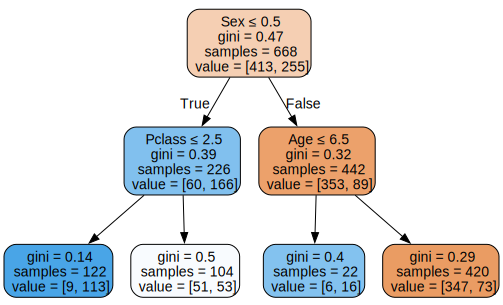

In [ ]:
draw_tree(m, trn_xs, size=10)

We can see that it's found exactly the same splits as we did!

In this picture, the more orange nodes have a lower survival rate, and blue have higher survival. Each node shows how many rows ("*samples*") match that set of rules, and shows how many perish or survive ("*values*"). There's also something called "*gini*". That's another measure of impurity, and it's very similar to the `score()` we created earlier. It's defined as follows:

In [ ]:
def gini(cond):
    """
    Compute the Gini impurity for a specified condition.

    Parameters:
    - cond: A boolean condition for filtering the dataframe.

    Returns:
    - The Gini impurity value for the filtered data.
    """
    
    # Use the given condition to filter the dataframe and select the dependent variable column
    act = df.loc[cond, dep]
    
    # Calculate the Gini impurity:
    # Gini impurity is calculated as 1 minus the sum of the squared probabilities of each class.
    # In a binary classification (e.g., 0 and 1), if 'act.mean()' gives the probability of class '1', 
    # then '1 - act.mean()' gives the probability of class '0'.
    # The formula then becomes: 1 - probability(1)^2 - probability(0)^2
    return 1 - act.mean()**2 - (1-act).mean()**2

What this calculates is the probability that, if you pick two rows from a group, you'll get the same `Survived` result each time. If the group is all the same, the probability is `1.0`, and `0.0` if they're all different:

In [ ]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

Let's see how this model compares to our OneR version:

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

0.19282511210762332

It's a tiny bit worse. Since this is such a small dataset (we've only got around 200 rows in our validation set) this small difference isn't really meaningful. Perhaps we'll see better results if we create a bigger tree:

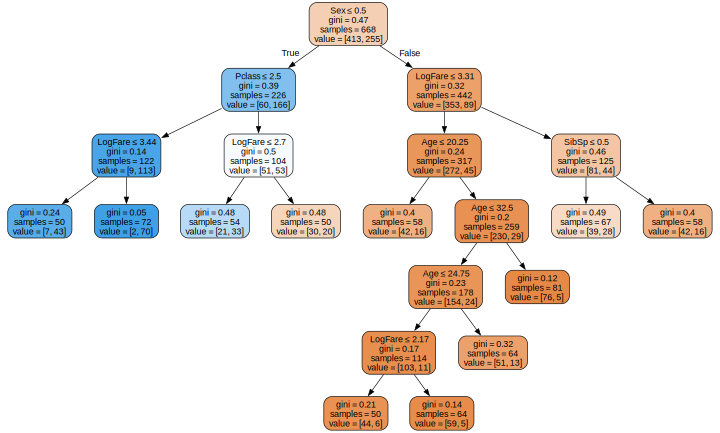

In [ ]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=10)

In [ ]:
mean_absolute_error(val_y, m.predict(val_xs))

0.15246636771300448

It looks like this is an improvement, although again it's a bit hard to tell with small datasets like this. Let's try submitting it to Kaggle:

In [ ]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'submission.csv', index=False)

subm(m.predict(tst_xs), 'tree')

When I submitted this, I got a score of 0.763.

## The random forest

We can't make the decision tree much bigger than the example above, since some leaf nodes already have only 50 rows in them. That's not a lot of data to make a prediction.

So how could we use bigger trees? One big insight came from Leo Breiman: what if we create lots of bigger trees, and take the average of their predictions? Taking the average prediction of a bunch of models in this way is known as [bagging](https://link.springer.com/article/10.1007/BF00058655).

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value -- that's because the average of lots of uncorrelated random errors is zero. That's quite an amazing insight!

One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data. Here's how we can create a tree on a random subset of the data:

In [ ]:
def get_tree(prop=0.85):
    """
    Generate and fit a decision tree classifier using a subset of the data.

    Parameters:
    - prop (float, optional): Proportion of the data to use for training. Default is 0.85.

    Returns:
    - A trained DecisionTreeClassifier.
    """

    # Determine the number of data points in the training set
    n = len(trn_y)
    
    # Randomly select a subset of indices based on the specified proportion
    idxs = random.choice(n, int(n*prop))
    
    # Train a DecisionTreeClassifier on the selected subset and return it
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

Now we can create as many trees as we want:

In [ ]:
trees = [get_tree() for t in range(100)]

Our prediction will be the average of these trees' predictions:

In [ ]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

This is nearly identical to what `sklearn`'s `RandomForestClassifier` does. The main extra piece in a "real" random forest is that as well as choosing a random sample of data for each tree, it also picks a random subset of columns for each split. Here's how we repeat the above process with a random forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

We can submit that to Kaggle too:

In [ ]:
subm(rf.predict(tst_xs), 'rf')

I found that gave nearly an identical result as our single tree.

One particularly nice feature of random forests is they can tell us which independent variables were the most important in the model, using `feature_importances_`:

In [ ]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

We can see that `Sex` is by far the most important predictor, with `Pclass` a distant second, and `LogFare` and `Age` behind that. In datasets with many columns, I generally recommend creating a feature importance plot as soon as possible, in order to find which columns are worth studying more closely. (Note also that we didn't really need to take the `log()` of `Fare`, since random forests only care about order, and `log()` doesn't change the order -- we only did it to make our graphs earlier easier to read.)

## Conclusion

First and foremost, complexity doesn't guarantee superiority in model performance. Our 'OneR' model, with just a single binary split, was nearly on par with the more intricate models. Such simplicity, at times, might be more practical and definitely worth consideration. Interestingly, our random forest did not outshine the lone decision tree.

It underscores the importance of benchmarking even the most rudimentary models, checking their adequacy for the task at hand. While it's true that for intricate tasks like recommendation systems, NLP, computer vision, or multivariate time series, simple models may falter, there's no harm in trying them out. After all, with the ease of testing various models, why not explore the simpler ones?

Lastly, let's not view random forests as overly intricate. Their essential features were seamlessly implemented in a notebook. Their resilience to challenges like normalization, interactions, or non-linear transformations makes them not only user-friendly but also less prone to errors.